<a href="https://colab.research.google.com/github/bominwang/Bayesian-statistics-method/blob/Bayesian-model-calibration/BC_MCMC_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
from google.colab import drive
drive.mount('/content/drive')
# 这里一定要加绝对绝对路径os.path.abspath
path = '/content/drive/MyDrive/Colab Notebooks/bm_wang/Bayesian_statistics_method/bayesian_model_averaging'
sys.path.append(os.path.abspath(path))

Mounted at /content/drive


In [2]:
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import seaborn

In [3]:
!pip install -U emcee
import emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 KB 2.7 MB/s eta 0:00:00


定义试验数据

In [4]:
ins_exp = np.array([1,7,14,21,28,90,180,270,360]).reshape(-1,1)
lab_exp = np.array([0.259,0.544,0.639,0.727,0.796,1.054,1.189,1.297,1.410]).reshape(-1,1)

导入待验证模型

In [5]:
from bma_demo import Mathematical_examples_1

原始参数空间下模型预测

In [ ]:
def displot_originalspace():
  x = np.linspace(1, 360, 1000).reshape(1000)
  # model1
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    #theta1 = np.random.uniform(low = 1.924 - 0.1 * 1.925, high = 1.924 * 0.1 + 1.924, size = [1000,1])
    #theta2 = np.random.uniform(low = 0.6 - 0.1 * 0.6, high = 0.6 * 0.1 + 0.6, size = [1000,1])
    theta1 = np.random.normal(1.94, 0.097, size = [1000, 1])
    theta2 = np.random.normal(0.6, 0.03, size = [1000, 1])
    input = np.concatenate((np.concatenate((ins * np.ones([1000,1]), theta1), axis = 1), theta2), axis = 1)
    y1 = Mathematical_examples_1.func_1(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-c', label = 'model1')
  plt.fill_between(x, mu_y1 - 1.96 * std_y1, mu_y1 + 1.96 * std_y1, alpha=0.4, color='c');
  plt.title('the prediction of model 1 under the original paramter space')
  plt.legend()
  plt.show()

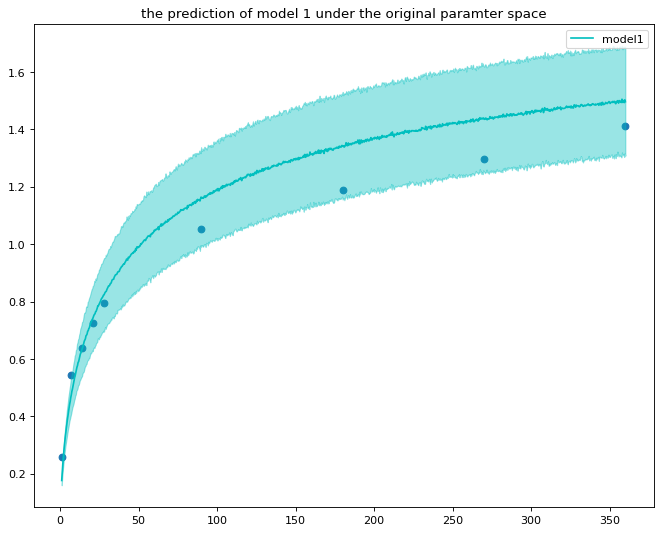

In [ ]:
displot_originalspace()

基于PYMC3的变分贝叶斯模型修正

假设预测数据和试验数据间的差异服从如下概率模型：

y_exp = y_model + epsilon

epsilon为零均值高斯分布，其方差通过最大似然估计求解

epsilon~N(O, sigma^2)

sigma = sum(power(y_exp - y_model, 2)) / N



In [ ]:
import scipy
from scipy import stats
class log_posterior(object):
  def __init__(self, ins_exp, out_exp, model):
    self.ins_exp = ins_exp.reshape(-1,1)
    self.lab_exp = lab_exp.reshape(-1,1)
    self.model = model
  
  def log_piror(self, theta):
    theta1, theta2 = theta
    if 1.924 - 0.1 * 1.925 < theta1 <1.924 + 0.1 * 1.925 and 0.6 - 0.1 * 0.6 < theta2 < 0.6 + 0.1 * 0.6 :
      return 0.0
      #return np.log(stats.uniform(1.924 - 0.1 * 1.924, 1.924 + 0.1 * 1.924).pdf(theta1)) + np.log(stats.uniform(0.6 - 0.1 * 0.6, 0.6 + 0.1 * 0.6).pdf(theta2))
      #return np.log(stats.norm(1.94, 0.097).pdf(theta1)) + np.log(stats.norm(1.94, 0.03).pdf(theta2))
    return -np.inf
  
  def sigma_c(self, theta):
    theta1, theta2 = theta
    theta1 = np.repeat(theta1, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    theta2 = np.repeat(theta2, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    input = np.concatenate([self.ins_exp, theta1, theta2], axis = 1)
    pred = self.model(input)
    sigma2 = np.mean(np.power(pred.reshape(-1, 1) - self.lab_exp, 2))
    return sigma2
  
  def log_likelihood(self, theta):
    theta1, theta2 = theta
    sigma2 = self.sigma_c(theta)
    log_lik = np.log(np.power(2 * np.pi * sigma2, - 0.5 * self.ins_exp.shape[0])) - 0.5 * self.ins_exp.shape[0]
    return log_lik
  
  def log_posterior(self, theta):
    lp = self.log_piror(theta)
    if not np.isfinite(lp):
      return -np.inf
    ll = self.log_likelihood(theta)
    return ll + lp

In [ ]:
from multiprocessing import Pool
# 开启并行

In [ ]:
ndim = 2
nwalkers = 500
pos = np.random.rand(nwalkers, ndim) * np.array([[0.1, 0.1]]) + np.array([[1.9, 0.6]])
with Pool() as pool:
  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior(ins_exp, lab_exp, Mathematical_examples_1.func_1).log_posterior, pool=pool)
  sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [02:58<00:00, 27.99it/s]


[1.874787   0.58035032]
[0.08485689 0.02739509]


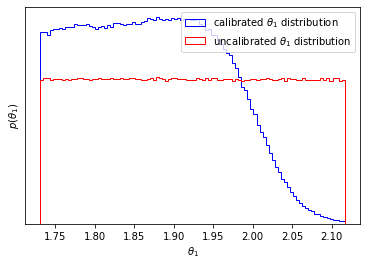

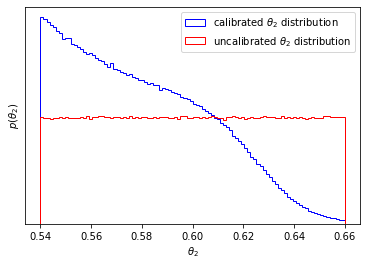

In [ ]:
samples = sampler.get_chain(flat=True)
print(np.mean(samples, axis=0))
print(np.std(samples, axis=0))
samples = sampler.get_chain(flat=True)
plt.figure(1)
original_theta1 = np.random.uniform(low = 1.924 - 0.1 * 1.925, high = 1.924 * 0.1 + 1.924, size = [samples[20000:,0].shape[0]])
#original_theta1 = np.random.normal(1.94, 0.097, size = [samples[2000:,0].shape[0]])
plt.hist(samples[20000:, 0], 100, color="b", histtype="step", label = r'calibrated $\theta_1$ distribution')
plt.hist(original_theta1, 100, color="r", histtype="step", label = r'uncalibrated $\theta_1$ distribution')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);
plt.figure(2)
original_theta2 = np.random.uniform(low = 0.6 - 0.1 * 0.6, high = 0.6 + 0.1 * 0.6, size = [samples[20000:,0].shape[0]])
#original_teeta2 = np.random.normal(0.6, 0.03, size = [samples[2000:,0].shape[0]])
plt.hist(samples[20000:, 1], 100, color="b", histtype="step", label = r'calibrated $\theta_2$ distribution')
plt.hist(original_theta2, 100, color="r", histtype="step", label = r'uncalibrated $\theta_2$ distribution')
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$p(\theta_2)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);

In [ ]:
def displot_calibrated_space(theta):
  x = np.linspace(1, 360, 1000).reshape(1000)
  # model1
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    theta1 = theta[:,0]
    theta2 = theta[:,1]
    input = np.concatenate((ins * np.ones([theta.shape[0],1]), theta1.reshape(-1,1), theta2.reshape(-1,1)), axis = 1)
    y1 = Mathematical_examples_1.func_1(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-c', label = 'model1')
  plt.fill_between(x, mu_y1 - 1.96 * std_y1, mu_y1 + 1.96 * std_y1, alpha=0.4, color='c');
  plt.title('the prediction of model 1 under the original paramter space')
  plt.legend()
  plt.show()

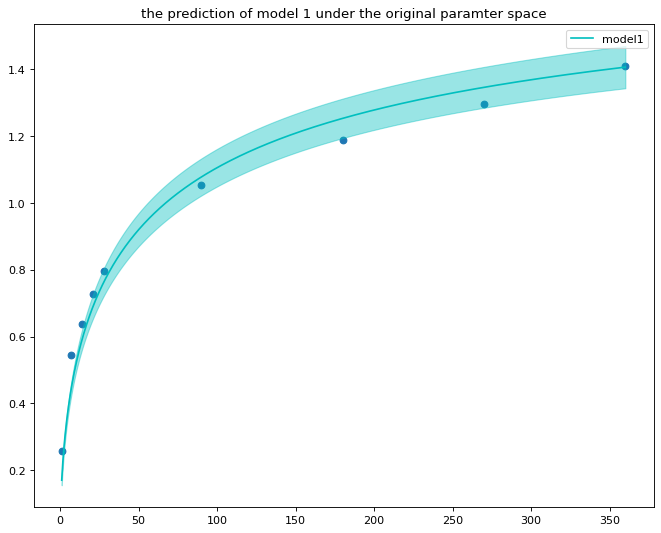

In [ ]:
displot_calibrated_space(samples[20000:,:])

Model 2

In [ ]:
def displot_originalspace():
  x = np.linspace(1, 360, 1000).reshape(1000)
  # model1
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    theta1 = np.random.uniform(low = 0.995 - 0.1 * 0.995, high = 0.995 + 0.1 * 0.995, size = [1000,1])
    theta2 = np.random.uniform(low = 24.65 - 0.1 * 24.65, high = 24.65 + 0.1 * 24.65, size = [1000,1])
    #theta1 = np.random.normal(1.94, 0.097, size = [1000, 1])
    #theta2 = np.random.normal(0.6, 0.03, size = [1000, 1])
    input = np.concatenate((np.concatenate((ins * np.ones([1000,1]), theta1), axis = 1), theta2), axis = 1)
    y1 = Mathematical_examples_1.func_2(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-r', label = 'model2')
  plt.fill_between(x, mu_y1 - 1.96 * std_y1, mu_y1 + 1.96 * std_y1, alpha=0.4, color='r');
  plt.title('the prediction of model 2 under the original paramter space')
  plt.legend()
  plt.show()

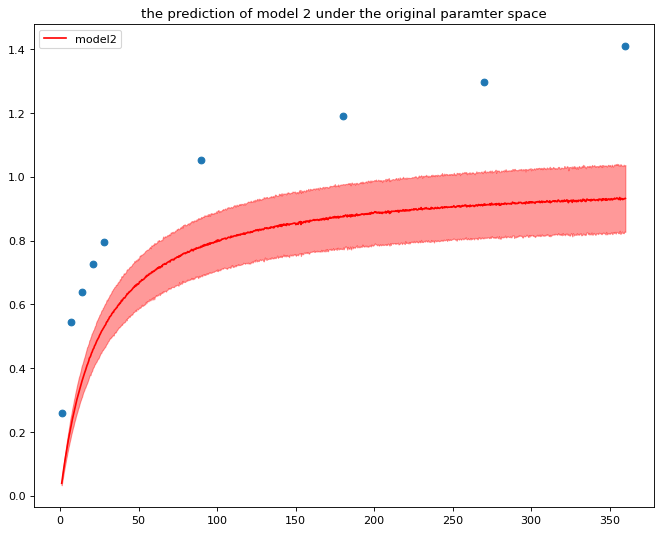

In [ ]:
displot_originalspace()

In [ ]:
import scipy
from scipy import stats
class log_posterior(object):
  def __init__(self, ins_exp, out_exp, model):
    self.ins_exp = ins_exp.reshape(-1,1)
    self.lab_exp = lab_exp.reshape(-1,1)
    self.model = model
  
  def log_piror(self, theta):
    theta1, theta2 = theta
    if 0.995 - 0.1 * 0.995 < theta1 < 0.995 + 0.1 * 0.995 and 24.65 - 0.1 * 24.65 < theta2 < 24.65 + 0.1 * 24.65:
      return 0.0
      #return np.log(stats.uniform(1.924 - 0.1 * 1.924, 1.924 + 0.1 * 1.924).pdf(theta1)) + np.log(stats.uniform(0.6 - 0.1 * 0.6, 0.6 + 0.1 * 0.6).pdf(theta2))
      #return np.log(stats.norm(1.94, 0.097).pdf(theta1)) + np.log(stats.norm(1.94, 0.03).pdf(theta2))
    return -np.inf
  
  def sigma_c(self, theta):
    theta1, theta2 = theta
    theta1 = np.repeat(theta1, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    theta2 = np.repeat(theta2, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    input = np.concatenate([self.ins_exp, theta1, theta2], axis = 1)
    pred = self.model(input)
    sigma2 = np.mean(np.power(pred.reshape(-1, 1) - self.lab_exp, 2))
    return sigma2
  
  def log_likelihood(self, theta):
    theta1, theta2 = theta
    sigma2 = self.sigma_c(theta)
    log_lik = np.log(np.power(2 * np.pi * sigma2, - 0.5 * self.ins_exp.shape[0])) - 0.5 * self.ins_exp.shape[0]
    return log_lik
  
  def log_posterior(self, theta):
    lp = self.log_piror(theta)
    if not np.isfinite(lp):
      return -np.inf
    ll = self.log_likelihood(theta)
    return ll + lp

In [ ]:
from multiprocessing import Pool
ndim = 2
nwalkers = 500
pos = np.random.rand(nwalkers, ndim) * np.array([[0.1, 0.1]]) + np.array([[0.995, 24.65]])
with Pool() as pool:
  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior(ins_exp, lab_exp, Mathematical_examples_1.func_2).log_posterior, pool=pool)
  sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [02:32<00:00, 32.75it/s]


[ 1.04404076 24.27960915]
[0.04498862 1.39639553]


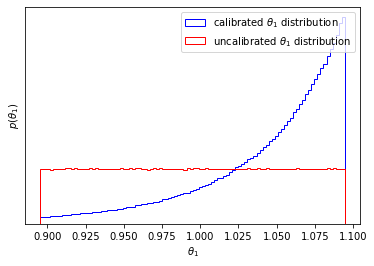

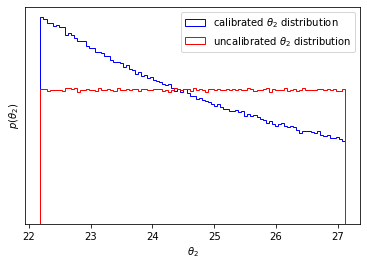

In [ ]:
samples = sampler.get_chain(flat=True)
print(np.mean(samples, axis=0))
print(np.std(samples, axis=0))
samples = sampler.get_chain(flat=True)
plt.figure(1)
original_theta1 = np.random.uniform(low = 0.995 - 0.1 * 0.995, high = 0.995 + 0.1 * 0.995, size = [samples[20000:,0].shape[0]])
plt.hist(samples[20000:, 0], 100, color="b", histtype="step", label = r'calibrated $\theta_1$ distribution')
plt.hist(original_theta1, 100, color="r", histtype="step", label = r'uncalibrated $\theta_1$ distribution')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);
plt.figure(2)
original_theta2 = np.random.uniform(low = 24.65 - 0.1 * 24.65, high = 24.65 + 0.1 * 24.65, size = [samples[20000:,0].shape[0]])
plt.hist(samples[20000:, 1], 100, color="b", histtype="step", label = r'calibrated $\theta_2$ distribution')
plt.hist(original_theta2, 100, color="r", histtype="step", label = r'uncalibrated $\theta_2$ distribution')
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$p(\theta_2)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);

In [ ]:
def displot_calibrated_space(theta):
  x = np.linspace(1, 360, 100).reshape(100)
  # model1
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    theta1 = theta[:,0]
    theta2 = theta[:,1]
    input = np.concatenate((ins * np.ones([theta.shape[0],1]), theta1.reshape(-1,1), theta2.reshape(-1,1)), axis = 1)
    y1 = Mathematical_examples_1.func_2(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-r', label = 'model2')
  plt.fill_between(x, mu_y1 - 1.96 * std_y1, mu_y1 + 1.96 * std_y1, alpha=0.4, color='r');
  plt.title('the prediction of model 2 under the calibrated paramter space')
  plt.legend()
  plt.show()

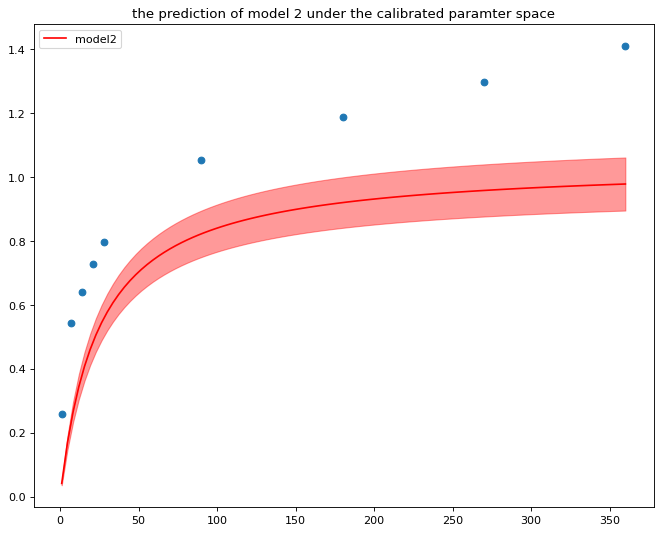

In [ ]:
displot_calibrated_space(samples[20000:,:])

model 3

In [49]:
def displot_originalspace():
  x = np.linspace(1, 360, 1000).reshape(1000)
  # model1
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    theta1 = np.random.uniform(low = 1.9, high = 2.4, size = [1000,1])
    theta2 = np.random.uniform(low = 330, high = 400, size = [1000,1])
    theta3 = np.random.uniform(low = 0.25, high = 0.4, size = [1000,1])
    input = np.concatenate((ins * np.ones([1000,1]), theta1, theta2, theta3), axis = 1)
    y1 = Mathematical_examples_1.func_3(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-g', label = 'model3')
  plt.fill_between(x, mu_y1 - 1.96 * std_y1, mu_y1 + 1.96 * std_y1, alpha=0.4, color='g');
  plt.title('the prediction of model 3 under the original paramter space')
  plt.legend()
  plt.show()

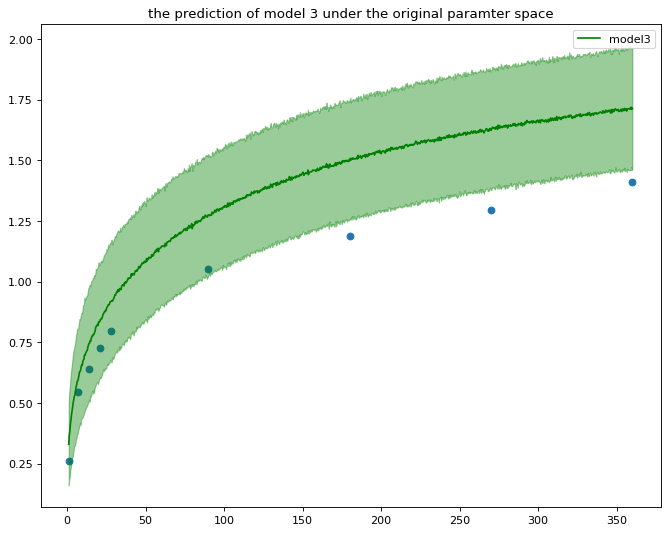

In [50]:
displot_originalspace()

In [43]:
import scipy
from scipy import stats
class log_posterior(object):
  def __init__(self, ins_exp, out_exp, model):
    self.ins_exp = ins_exp.reshape(-1,1)
    self.lab_exp = lab_exp.reshape(-1,1)
    self.model = model
  
  def log_piror(self, theta):
    theta_min = np.array([1.9, 330, 0.25])
    theta_max = np.array([2.4, 400, 0.40])
    theta1, theta2, theta3 = theta
    #if 2.265 - 0.1 * 2.265 < theta1 < 2.265 + 0.1 * 2.265 and 364.21 - 0.1 * 364.21 < theta2 < 364.21 + 0.1 * 364.21 and 0.3 - 0.1 *  0.3 < theta3 < 0.3 + 0.1 *  0.3:
    if theta_min[0]<theta1<theta_max[0] and theta_min[1]<theta1<theta_max[1] and theta_min[2]<theta3<theta_max[2]:
      #return stats.uniform.logpdf(theta1, theta_min[0], theta_max[0] - theta_min[0]) + stats.uniform.logpdf(theta2, theta_min[1], theta_max[1] - theta_min[1]) + stats.uniform.logpdf(theta3, theta_min[2], theta_max[2] - theta_min[2])
      return 0.0
    return -np.inf
  
  def sigma_c(self, theta):
    theta1, theta2, theta3 = theta
    theta1 = np.repeat(theta1, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    theta2 = np.repeat(theta2, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    theta3 = np.repeat(theta3, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    
    input = np.concatenate([self.ins_exp, theta1, theta2, theta3], axis = 1)
    pred = self.model(input)
    sigma2 = np.mean(np.power(pred.reshape(-1, 1) - self.lab_exp, 2))
    
    return sigma2
  
  def log_likelihood(self, theta):
    theta1, theta2, theta3 = theta
    sigma2 = self.sigma_c(theta)
    log_lik = np.log(np.power(2 * np.pi * sigma2, - 0.5 * self.ins_exp.shape[0])) - 0.5 * self.ins_exp.shape[0]
    return log_lik
  
  def log_posterior(self, theta):
    lp = self.log_piror(theta)
    if not np.isfinite(lp):
      return -np.inf
    ll = self.log_likelihood(theta)
    return ll + lp

In [45]:
from multiprocessing import Pool
ndim = 3
nwalkers = 500
pos = np.random.rand(nwalkers, ndim) * np.array([[0.1, 0.1, 0.1]]) + np.array([[2.265, 364.21, 0.3]])
with Pool() as pool:
  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior(ins_exp, lab_exp, Mathematical_examples_1.func_3).log_posterior, pool=pool)
  sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [01:09<00:00, 72.07it/s]


[2.31385962e+00 3.64259984e+02 3.49513735e-01]
[0.02821097 0.02863236 0.02836688]


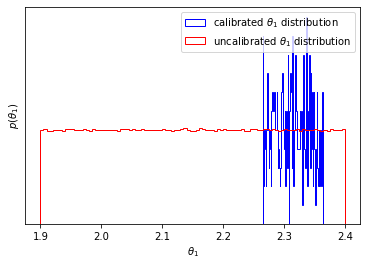

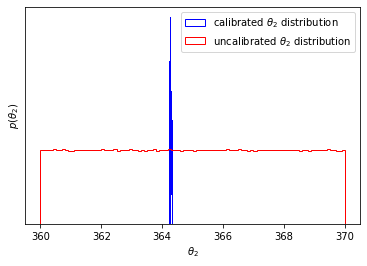

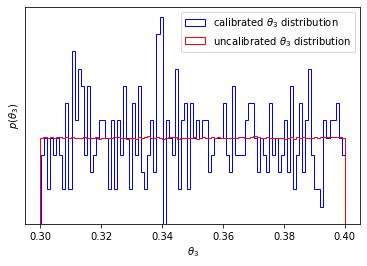

In [51]:
samples = sampler.get_chain(flat=True)
print(np.mean(samples, axis=0))
print(np.std(samples, axis=0))
samples = sampler.get_chain(flat=True)
plt.figure(1)
original_theta1 = np.random.uniform(low = 1.9, high = 2.4, size = [samples[20000:,0].shape[0]])
plt.hist(samples[20000:, 0], 100, color="b", histtype="step", label = r'calibrated $\theta_1$ distribution')
plt.hist(original_theta1, 100, color="r", histtype="step", label = r'uncalibrated $\theta_1$ distribution')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);
plt.figure(2)
original_theta2 = np.random.uniform(low = 360, high = 370, size = [samples[20000:,0].shape[0]])
plt.hist(samples[20000:, 1], 100, color="b", histtype="step", label = r'calibrated $\theta_2$ distribution')
plt.hist(original_theta2, 100, color="r", histtype="step", label = r'uncalibrated $\theta_2$ distribution')
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$p(\theta_2)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);
plt.figure(3)
original_theta3 = np.random.uniform(low = 0.3, high = 0.4, size = [samples[20000:,0].shape[0]])
plt.hist(samples[20000:, 2], 100, color="b", histtype="step", label = r'calibrated $\theta_3$ distribution')
plt.hist(original_theta3, 100, color="r", histtype="step", label = r'uncalibrated $\theta_3$ distribution')
plt.xlabel(r"$\theta_3$")
plt.ylabel(r"$p(\theta_3)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);

In [47]:
def displot_calibrated_space(theta):
  x = np.linspace(1, 360, 100).reshape(100)
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    theta1 = theta[:,0]
    theta2 = theta[:,1]
    theta3 = theta[:,2]
    input = np.concatenate((ins * np.ones([theta.shape[0],1]), theta1.reshape(-1,1), theta2.reshape(-1,1), theta3.reshape(-1,1)), axis = 1)
    y1 = Mathematical_examples_1.func_3(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-g', label = 'model3')
  plt.fill_between(x, mu_y1 - 1.96 * std_y1, mu_y1 + 1.96 * std_y1, alpha=0.4, color='g');
  plt.title('the prediction of model 3 under the calibrated paramter space')
  plt.legend()
  plt.show()

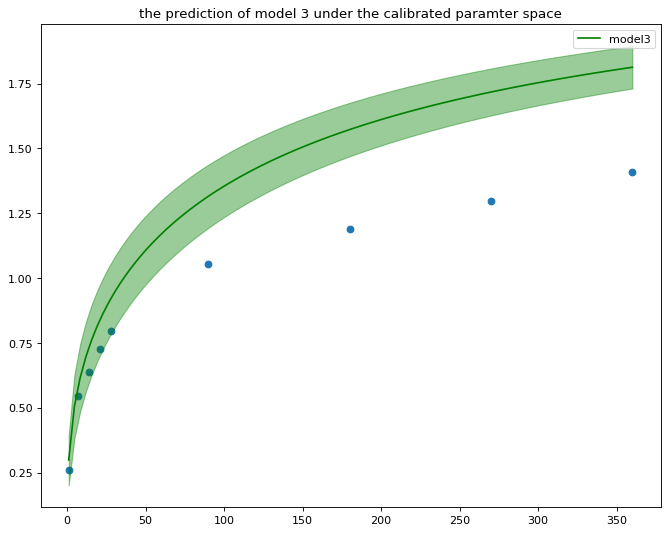

In [48]:
displot_calibrated_space(samples[20000:,:])

model 4

In [29]:
def displot_originalspace():
  x = np.linspace(1, 360, 1000).reshape(1000)
  # model1
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    theta1 = np.random.uniform(low = 1.541 - 0.1 * 1.541, high = 1.541 + 0.1 * 1.541, size = [1000,1])
    theta2 = np.random.uniform(low = 0.14, high = 0.26, size = [1000,1])
    theta3 = np.random.uniform(low = 0.54, high = 0.7, size = [1000,1])
    input = np.concatenate((ins * np.ones([1000,1]), theta1, theta2, theta3), axis = 1)
    y1 = Mathematical_examples_1.func_4(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-m', label = 'model4')
  plt.fill_between(x, mu_y1 - 1.96 * std_y1, mu_y1 + 1.96 * std_y1, alpha=0.4, color='m');
  plt.title('the prediction of model 4 under the original paramter space')
  plt.legend()
  plt.show()

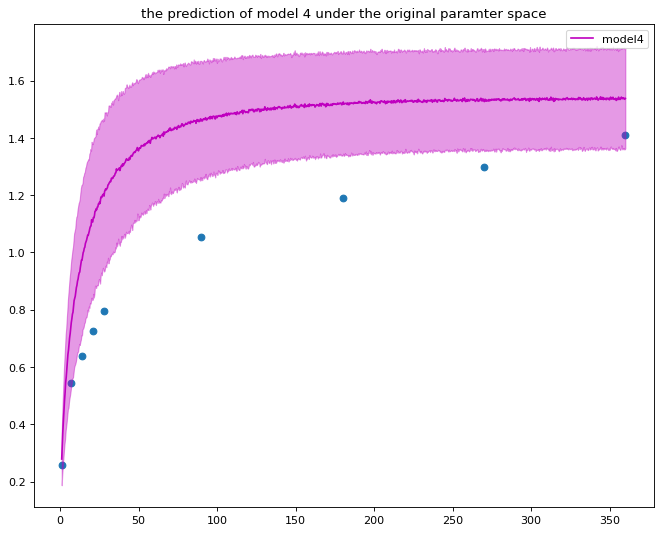

In [30]:
displot_originalspace()

In [23]:
import scipy
from scipy import stats
class log_posterior(object):
  def __init__(self, ins_exp, out_exp, model):
    self.ins_exp = ins_exp.reshape(-1,1)
    self.lab_exp = lab_exp.reshape(-1,1)
    self.model = model
  
  def log_piror(self, theta):
    theta1, theta2, theta3 = theta
    #if 1.541 - 0.1 * 1.541 < theta1 < 1.541 + 0.1 * 1.541 and 0.097 - 0.1 * 0.097 < theta2 < 0.097 + 0.1 * 0.097 and 0.6 - 0.1 *  0.6 < theta3 < 0.6 + 0.1 *  0.6:
    if 1.541 - 0.1 * 1.541 < theta1 < 1.541 + 0.1 * 1.541 and 0.14 < theta2 < 0.26 and 0.54 < theta3 < 0.7:
      return 0.0
    return -np.inf
  
  def sigma_c(self, theta):
    theta1, theta2, theta3 = theta
    theta1 = np.repeat(theta1, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    theta2 = np.repeat(theta2, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    theta3 = np.repeat(theta3, self.ins_exp.shape[0], axis = 0).reshape(-1, 1)
    
    input = np.concatenate([self.ins_exp, theta1, theta2, theta3], axis = 1)
    pred = self.model(input)
    sigma2 = np.mean(np.power(pred.reshape(-1, 1) - self.lab_exp, 2))
    
    return sigma2
  
  def log_likelihood(self, theta):
    theta1, theta2, theta3 = theta
    sigma2 = self.sigma_c(theta)
    log_lik = np.log(np.power(2 * np.pi * sigma2, - 0.5 * self.ins_exp.shape[0])) - 0.5 * self.ins_exp.shape[0]
    return log_lik
  
  def log_posterior(self, theta):
    lp = self.log_piror(theta)
    if not np.isfinite(lp):
      return -np.inf
    ll = self.log_likelihood(theta)
    return ll + lp

In [24]:
from multiprocessing import Pool
ndim = 3
nwalkers = 500
pos = np.random.rand(nwalkers, ndim) * np.array([[0.1, 0.1, 0.1]]) + np.array([[1.541, 0.16, 0.6]])
with Pool() as pool:
  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior(ins_exp, lab_exp, Mathematical_examples_1.func_4).log_posterior, pool=pool)
  sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [03:24<00:00, 24.44it/s]


[1.40877161 0.14740597 0.55085792]
[0.0254205  0.00880413 0.01382666]


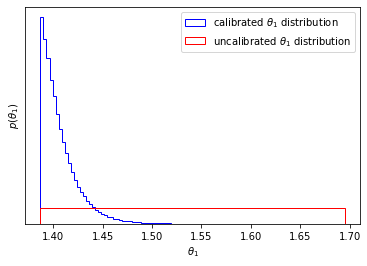

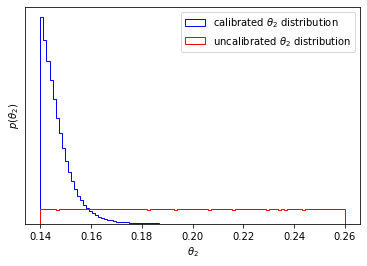

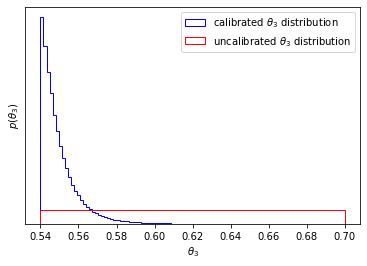

In [26]:
samples = sampler.get_chain(flat=True)
print(np.mean(samples, axis=0))
print(np.std(samples, axis=0))
samples = sampler.get_chain(flat=True)
plt.figure(1)
original_theta1 = np.random.uniform(low = 1.541 - 0.1 * 1.541, high = 1.541 + 0.1 * 1.541, size = [samples[20000:,0].shape[0]])
plt.hist(samples[20000:, 0], 100, color="b", histtype="step", label = r'calibrated $\theta_1$ distribution')
plt.hist(original_theta1, 100, color="r", histtype="step", label = r'uncalibrated $\theta_1$ distribution')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);
plt.figure(2)
original_theta2 = np.random.uniform(low = 0.14, high = 0.26, size = [samples[10000:,0].shape[0]])
plt.hist(samples[10000:, 1], 100, color="b", histtype="step", label = r'calibrated $\theta_2$ distribution')
plt.hist(original_theta2, 100, color="r", histtype="step", label = r'uncalibrated $\theta_2$ distribution')
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$p(\theta_2)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);
plt.figure(3)
original_theta3 = np.random.uniform(low = 0.54, high = 0.7, size = [samples[20000:,0].shape[0]])
plt.hist(samples[20000:, 2], 100, color="b", histtype="step", label = r'calibrated $\theta_3$ distribution')
plt.hist(original_theta3, 100, color="r", histtype="step", label = r'uncalibrated $\theta_3$ distribution')
plt.xlabel(r"$\theta_3$")
plt.ylabel(r"$p(\theta_3)$")
plt.legend(loc = 1)
plt.gca().set_yticks([]);

In [27]:
def displot_calibrated_space(theta):
  x = np.linspace(1, 360, 100).reshape(100)
  mu_y1 = []
  std_y1 = []
  for i in range(x.shape[0]):
    ins = x[i]
    theta1 = theta[:,0]
    theta2 = theta[:,1]
    theta3 = theta[:,2]
    input = np.concatenate((ins * np.ones([theta.shape[0],1]), theta1.reshape(-1,1), theta2.reshape(-1,1), theta3.reshape(-1,1)), axis = 1)
    y1 = Mathematical_examples_1.func_4(input)
    mu = np.mean(y1, axis = 0)
    std = np.std(y1, axis = 0)
    mu_y1.append(mu)
    std_y1.append(std)
  my_y1 = np.array(mu_y1)
  std_y1 = np.array(std_y1)
  plt.figure(1, figsize=(10, 8), dpi=80)
  plt.scatter(ins_exp, lab_exp)
  plt.plot(x, mu_y1, '-m', label = 'model4')
  plt.fill_between(x, mu_y1 - 1.96 * std_y1, mu_y1 + 1.96 * std_y1, alpha=0.4, color='m');
  plt.title('the prediction of model 4 under the calibrated paramter space')
  plt.legend()
  plt.show()

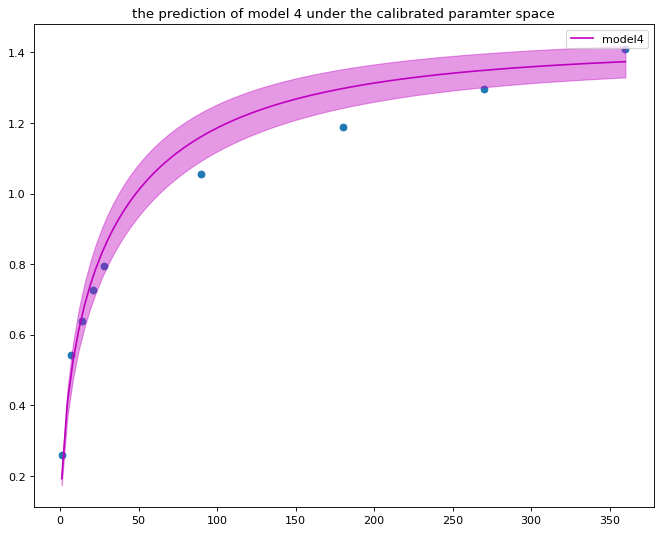

In [28]:
displot_calibrated_space(samples[20000:,:])